In [46]:
from sqlalchemy import create_engine
import datetime as dt
import pandas as pd
import sqlite3
import xgboost as xgb
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
from collections import Counter
import numpy as np
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
import os
from sklearn.calibration import CalibratedClassifierCV

In [47]:
import time
from dask import dataframe as df1
if not os.path.isfile('train.db'):  
    # time taken to read data
    s_time_dask = time.time()
    dask_df = df1.read_csv('final_features.csv')
    e_time_dask = time.time()
    conn='sqlite:///train.db'
    dask_df.to_sql('data', conn, if_exists='append')
    print("done")


done


In [48]:
dask_df.head(10)

,Unnamed: 0,id,is_duplicate,freq_qid1_x,freq_qid2_x,q1len_x,q2len_x,q1_n_words_x,q2_n_words_x,word_Common_x,word_Total_x,word_share_x,freq_q1+q2_x,freq_q1-q2_x,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1_y,freq_qid2_y,q1len_y,q2len_y,q1_n_words_y,q2_n_words_y,word_Common_y,word_Total_y,word_share_y,freq_q1+q2_y,freq_q1-q2_y,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,...,54.131466,-25.001363,-2.687677,21.730646,-45.651222,-16.713844,-9.407810,-32.826955,-28.381217,-20.902052,0.441423,16.390758,-59.488662,-39.327058,-3.263883,4.978999,6.368590,14.606946,-26.981325,43.716049,-0.507561,10.547924,-45.735124,60.214244,19.914113,-21.147434,27.948786,21.574821,18.194029,32.880215,28.148557,1.353426,-11.824832,11.047364,-46.344915,-48.177285,43.835798,34.804433,9.032388,-10.397838
1,1,1,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,...,35.849696,-48.256575,-35.202013,-7.905145,10.715062,-20.051764,58.063669,-76.080980,-8.513697,-17.021134,9.548022,7.922542,14.087246,-63.397207,22.651886,6.324106,39.661608,6.441556,-77.517264,50.144316,-22.293042,45.400544,-48.041240,10.767362,-4.182741,-41.064394,59.959707,-5.135146,-19.527649,21.221412,9.847467,-6.033736,-41.089482,14.710476,-2.296005,-41.452763,-8.047269,32.255540,49.435565,7.736123
2,2,2,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,...,1.175416,-13.628969,-49.200688,-6.667256,-16.030736,-10.778536,-10.080746,-25.139970,-26.757342,14.133521,13.704903,27.598356,-23.600721,-49.139185,-5.219456,-7.540711,-36.198548,-20.781950,-38.778317,35.890232,-1.818421,21.088509,-29.817724,41.068801,13.477527,-59.456928,11.373762,30.597513,-15.104664,39.227311,17.234993,-16.020391,11.371595,38.165778,-58.871167,-58.693419,25.354102,-8.443740,18.219822,4.179060
3,3,3,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,...,4.890617,-6.645367,-28.713241,8.498183,0.767183,1.441456,4.213331,-7.799716,-3.068507,-20.190375,-14.114701,5.402018,-11.318029,-20.165190,-5.048484,-8.578867,7.256838,-1.774074,-22.037444,11.174666,12.381307,4.644106,-13.807170,27.074503,15.625699,-14.388126,25.678348,-0.841416,-10.032705,-0.671856,-0.328735,2.499035,13.687266,14.945740,-38.077528,-27.151421,-10.715018,-11.844042,7.744054,-38.738767
4,4,4,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,...,25.030861,-22.204118,-9.340205,20.690796,-46.295719,-2.317739,-9.914898,-15.815479,-30.105115,-6.554042,-8.660563,16.339977,-13.147459,-22.405143,-0.537721,2.518606,5.072811,-9.170837,-29.989794,21.701245,9.078663,24.330509,-16.767228,34.346081,10.743587,-26.552387,11.099969,16.053087,-6.058818,23.679285,9.265314,6.862892,-24.873213,18.215862,-8.750962,-22.902637,24.033332,-9.201688,23.656202,0.068455
5,5,5,1,1,1,86,90,16,16,8.0,31.0,0.258065,2,0,0.666656,0.571420,0.888879,0.799992,0.705878,0.705878,1.0,0.0,0.0,17.0,81,77,73,73,0.160920,1,1,86,90,16,16,8.0,31.0,0.258065,2,0,...,17.987773,4.823613,-45.651244,-18.089604,-12.064070,-36.674023,40.885232,-19.295294,28.538791,-20.035578,2.781038,5.454672,-3.016587,-46.036249,30.798531,28.252137,-17.174716,-0.567673,-41.650636,-1.50435

* you might observe later column values coming as Nan , this is because of low memory
* Look out for the error 
### Sol : 
* I replaced the traditional way by dusk 
* works like a charm

In [49]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [50]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [51]:
conn_r = create_connection(read_db)
if conn_r is not None:
	# for selecting first 1M rows
	# data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
	
	# for selecting random points
	data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 10001;", conn_r)
	conn_r.commit()
	conn_r.close()
else :
    print("not connected")

In [52]:
data.head(5)

,index,Unnamed: 0,id,is_duplicate,freq_qid1_x,freq_qid2_x,q1len_x,q2len_x,q1_n_words_x,q2_n_words_x,word_Common_x,word_Total_x,word_share_x,freq_q1+q2_x,freq_q1-q2_x,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1_y,freq_qid2_y,q1len_y,q2len_y,q1_n_words_y,q2_n_words_y,word_Common_y,word_Total_y,word_share_y,freq_q1+q2_y,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,4683,152468,152469,0,4,1,46,71,9,14,2.0,23.0,0.086957,5,3,0.499988,0.222220,0.199996,0.199996,0.333330,0.214284,0.0,0.0,5.0,11.5,50,45,35,46,0.276596,4,1,46,71,9,14,2.0,23.0,0.086957,5,...,6.939786,19.951387,-20.771957,-5.108500,-17.194986,-13.316422,13.984036,-13.086893,-8.467644,-10.345524,-2.546248,0.507135,-4.460636,-22.317044,22.005614,17.910783,-20.601219,5.592316,-13.286132,44.505026,-13.993367,4.435058,-18.369416,34.914702,-3.260805,-20.544516,56.252771,-5.273548,23.156254,-8.758995,-13.513644,-9.016383,-28.115513,3.390287,-16.964178,-15.317848,1.743160,7.008514,12.665528,-17.064027
1,13844,260117,260119,1,6,23,50,37,10,7,3.0,16.0,0.187500,29,17,0.499975,0.249994,0.399992,0.399992,0.428565,0.299997,0.0,1.0,3.0,8.5,62,56,61,70,0.342105,6,23,50,37,10,7,3.0,16.0,0.187500,29,...,6.526430,6.891256,-30.271523,-2.928030,-32.950694,-32.621256,16.671552,-16.546826,31.104878,-22.519359,-1.949961,-3.116676,-12.411117,-40.156640,-9.743773,16.191297,-37.228889,21.444384,-14.314131,8.091951,-16.376860,35.562201,-30.812788,25.907772,36.677653,-28.076928,38.052339,2.385142,43.143972,-5.771243,-5.206880,17.611333,-14.328885,23.551879,-23.385970,-28.290991,19.693926,31.914642,-11.132498,54.207750
2,13638,292740,292742,0,1,1,50,144,9,29,2.0,35.0,0.057143,2,0,0.000000,0.000000,0.399992,0.199998,0.222220,0.066666,0.0,0.0,21.0,19.5,34,31,17,32,0.117647,1,1,50,144,9,29,2.0,35.0,0.057143,2,...,-12.590967,-9.332591,-16.882506,12.388417,2.436095,3.096167,-1.274367,-11.870275,-23.982117,-6.364122,9.029601,-1.746996,-7.412954,-31.998844,-0.786513,2.869684,-11.039107,-8.956932,-16.761378,7.809539,-1.853859,0.249191,9.880525,1.926524,-17.202833,-26.018240,8.879312,16.892842,-0.664988,18.840524,-5.103010,1.511512,18.071807,21.372644,-21.804874,-4.534084,1.886563,-0.234101,2.155765,-16.998454
3,4396,365566,365569,0,1,1,34,33,7,7,6.0,14.0,0.428571,2,0,0.666644,0.666644,0.999975,0.999975,0.857131,0.857131,1.0,1.0,0.0,7.0,89,89,89,88,0.470588,1,1,34,33,7,7,6.0,14.0,0.428571,2,...,12.536736,1.681189,-28.774282,12.982684,-20.934011,-6.710458,-7.253946,-49.961812,-14.986511,-23.850546,-17.731557,6.006616,-9.818306,-45.142214,9.897986,-22.713067,-7.316367,-4.013683,-24.695024,25.159325,13.962618,10.555278,-25.954887,28.428914,-8.993225,-13.502511,28.202369,20.136872,24.188351,0.094213,22.609088,-1.732343,-22.849717,18.424999,-31.914144,-25.277302,17.494472,26.116630,4.116943,9.458239
4,3672,85789,85789,1,1,1,135,53,22,9,5.0,31.0,0.161290,2,0,0.666656,0.266665,0.333322,0.124998,0.555549,0.217390,0.0,0.0,14.0,16.0,72,52,45,66,0.314815,1,1,135,53,22,9,5.0,31.0,0.161290,2,...,-2.386971,-26.145068,-20.244598,17.677777,-32.862172,-18.175589,11.270093,-43.837610,-6.047416,-19.292919,-16.124296,16.039754,-17.227107,-41.301163,4.633917,11.901747,-7.352499,14.152987,-3.355518,32.729582,-17.415667,9.358613,-49.611087,24.062866,-1.218962,-40.109799,51.264481,19.163089,19.893931,-2.841950,25.397629,20.321738,-19.577937,15.502667,-39.614396,-55.881948,7.592069,34.715737,-10.390572,25.004274


In [53]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [54]:
# cols = list(data.columns)
# cols

### after we read from sql table each entry was read it as a string
### we convert all the features into numaric before we apply any model

In [55]:
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)

In [56]:
#convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

In [57]:
#split( 70:30) 
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [58]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6325714285714286 Class 1:  0.36742857142857144
---------- Distribution of output variable in train data ----------
Class 0:  0.36733333333333335 Class 1:  0.36733333333333335


In [59]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

* Building a random model (Finding worst-case log-loss) 

Log loss on Test Data using Random Model 0.8912516548686258


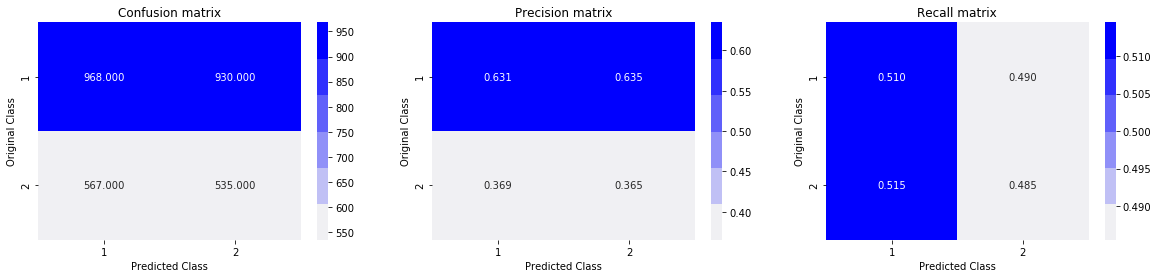

In [60]:
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [61]:
# Logistic Regression with hyperparameter tuning 

In [62]:
X_train.head(5)

,freq_qid1_x,freq_qid2_x,q1len_x,q2len_x,q1_n_words_x,q2_n_words_x,word_Common_x,word_Total_x,word_share_x,freq_q1+q2_x,freq_q1-q2_x,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1_y,freq_qid2_y,q1len_y,q2len_y,q1_n_words_y,q2_n_words_y,word_Common_y,word_Total_y,word_share_y,freq_q1+q2_y,freq_q1-q2_y,0_x,1_x,2_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
4328,1,1,46,46,8,8,5.0,16.0,0.312500,2,0,0.499988,0.499988,0.749981,0.749981,0.624992,0.624992,1.0,1.0,0.0,8.0,68,60,69,70,0.361702,1,1,46,46,8,8,5.0,16.0,0.312500,2,0,42.402011,88.403851,1.492384,...,-1.300670,2.927420,-35.467605,13.462469,-20.707826,-17.238826,0.444309,21.962251,22.975181,-28.791129,12.857540,-7.321658,-35.608078,34.143688,0.666107,18.022315,31.487802,0.561387,-12.330163,30.096835,-26.783922,3.354277,-42.455305,15.592298,46.075156,-8.467655,16.490604,-12.631009,18.376942,27.577942,1.691904,8.188753,-39.437398,9.601695,15.157251,-15.910614,-1.218145,20.571797,21.894134,2.516057
442,2,1,86,60,15,11,2.0,25.0,0.080000,3,1,0.285710,0.222220,0.000000,0.000000,0.181817,0.133332,1.0,0.0,4.0,13.0,46,48,46,42,0.229508,2,1,86,60,15,11,2.0,25.0,0.080000,3,1,32.949343,-4.265883,-20.056994,...,4.354791,-16.857599,-14.691509,-5.850375,-23.859005,10.178562,31.858622,-16.096401,-32.202126,-11.225398,7.151125,5.809113,-30.373251,-45.719347,-7.113944,3.760764,30.623989,7.678961,-29.339113,20.423749,-32.464468,33.943990,-8.402590,21.944470,-16.316641,-26.215071,17.144945,26.881498,-2.337712,30.092027,-1.496609,29.485351,11.692760,23.991221,-1.877535,-36.996989,14.978483,-10.446673,24.476798,-8.390189
4266,7,17,44,58,9,11,6.0,20.0,0.300000,24,10,0.749981,0.499992,0.799984,0.799984,0.777769,0.636358,0.0,1.0,2.0,10.0,82,65,70,64,0.400000,7,17,44,58,9,11,6.0,20.0,0.300000,24,10,15.999249,5.237183,5.459068,...,-5.366946,-3.112915,-34.682589,-3.106021,36.152561,6.118206,-25.596763,-14.602774,7.531618,8.896748,-27.421957,-5.394609,-30.840745,-21.751458,12.169022,32.521680,-13.574974,7.417587,-1.166640,29.786057,15.716672,10.215242,-27.943476,15.683054,9.732742,-12.797247,12.745460,-9.282728,-13.902696,-3.914594,-0.883935,10.675640,-17.438909,1.406357,-27.095834,4.835193,5.499164,4.939328,4.698929,-17.358206
6253,2,1,89,50,19,11,6.0,29.0,0.206897,3,1,0.333328,0.249997,0.999980,0.499995,0.636358,0.368419,0.0,1.0,8.0,15.0,73,56,47,56,0.196078,2,1,89,50,19,11,6.0,29.0,0.206897,3,1,3.855783,9.242043,-3.419277,...,6.771432,18.767370,2.792225,17.841443,-3.371377,-5.299558,0.702478,-4.002541,-19.841073,-9.925510,-7.930439,-3.474235,-22.418010,-17.994543,13.087095,3.890191,-10.816137,3.314790,-10.357500,25.407148,-3.893151,12.808331,-10.738450,21.117441,-0.787040,-19.476560,9.475765,-8.617610,-2.946705,-14.846758,14.281472,7.522449,-0.078996,28.451371,10.933102,-25.953438,5.632777,-8.218754,3.181914,-9.528175
8554,1,1,34,40,7,7,2.0,14.0,0.142857,2,0,0.499988,0.399992,0.000000,0.000000,0.285710,0.285710,0.0,0.0,0.0,7.0,61,53,53,53,0.428571,1,1,34,40,7,7,2.0,14.0,0.142857,2,0,1.020611,-9.672411,9.943939,...,62.623511,-28.796525,5.866708,4.954698,-11.571157,-2.989882,-37.364732,-19.669311,-8.215437,-30.949563,-39.792830,31.792363,-33.012943,-23.943251,9.372036,15.830929,-54.976718,3.786605,-47.684580,93.848525,-9.426729,-15.046816,-52.663983,67.206683,13.193802,-25.547514,75.054129,27.387526,23.064840,34.646102,32.844169,21.443759,-33.596837,-14.236113,-55.435305,-86.477949,26.628193,34.355294,18.821109,-36.577939


For values of alpha =  1e-05 The log loss is: 0.6575213412002966
For values of alpha =  0.0001 The log loss is: 0.4872217469140363
For values of alpha =  0.001 The log loss is: 0.48911378156143165
For values of alpha =  0.01 The log loss is: 0.4829722809804077
For values of alpha =  0.1 The log loss is: 0.4708801220515511
For values of alpha =  1 The log loss is: 0.4981751019067448
For values of alpha =  10 The log loss is: 0.5391778224996143


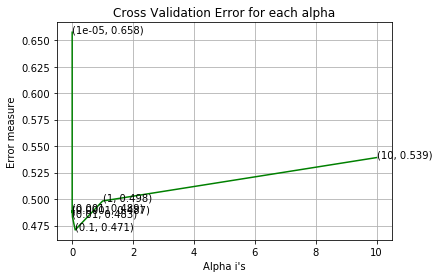

For values of best alpha =  0.1 The train log loss is: 0.4508693934445013
For values of best alpha =  0.1 The test log loss is: 0.4708801220515511
Total number of data points : 3000


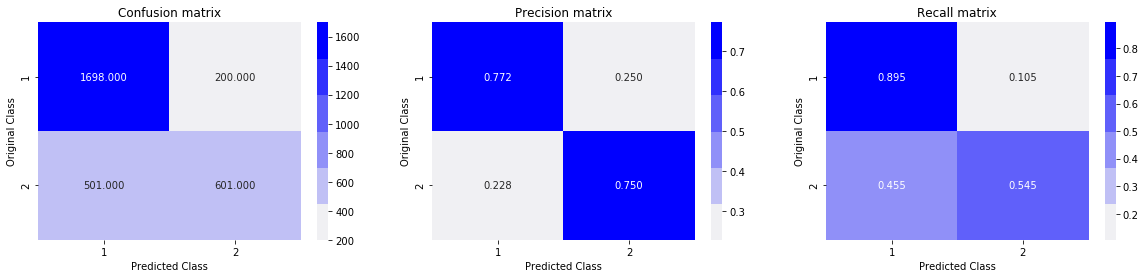

In [63]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [64]:
# XGBoost 

In [65]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684381	valid-logloss:0.684775
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.612413	valid-logloss:0.615891
[20]	train-logloss:0.558898	valid-logloss:0.564867
[30]	train-logloss:0.518467	valid-logloss:0.526031
[40]	train-logloss:0.487126	valid-logloss:0.49636
[50]	train-logloss:0.462786	valid-logloss:0.473524
[60]	train-logloss:0.443213	valid-logloss:0.455262
[70]	train-logloss:0.427394	valid-logloss:0.440652
[80]	train-logloss:0.414256	valid-logloss:0.428411
[90]	train-logloss:0.403395	valid-logloss:0.418527
[100]	train-logloss:0.394281	valid-logloss:0.410576
[110]	train-logloss:0.386585	valid-logloss:0.403807
[120]	train-logloss:0.379624	valid-logloss:0.398019
[130]	train-logloss:0.37369	valid-logloss:0.393304
[140]	train-logloss:0.36851	valid-logloss:0.389141
[150]	train-logloss:0.363982	valid-logloss:0.385717
[160]	train-logloss:0.36009	val

Total number of data points : 3000


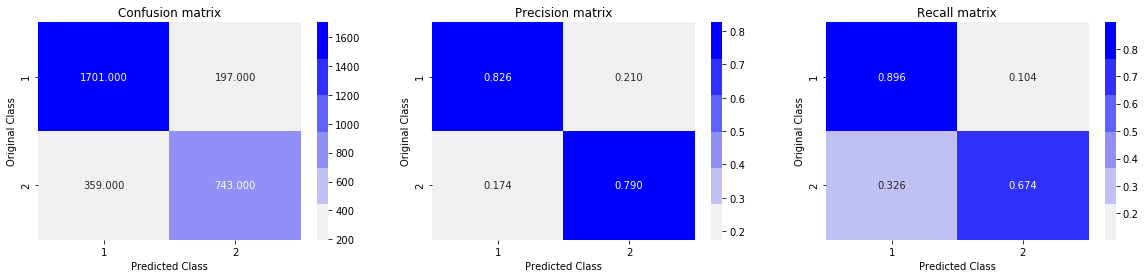

In [66]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

** XG boost classifications are better compared to other models used